В данном задании вам нужно будет

проанализировать АБ тест, проведенный на реальных пользователях Яндекса
подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
определить характер этих изменений и практическую значимость вводимого изменения
понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)
Описание данных:

userID: уникальный идентификатор пользователя
browser: браузер, который использовал userID
slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
n_clicks: количество кликов, которые пользоваль совершил за n_queries
n_queries: количество запросов, который совершил userID, пользуясь браузером browser
n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика
Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

ab_browser_test.csv

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

In [18]:
%pylab inline
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [42]:
data = pd.read_csv('ab_browser_test.csv')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [15]:
data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [6]:
data_exp = data[data.slot == 'exp']
data_control = data[data.slot == 'control']

sum_clicks_exp = sum(data_exp.n_clicks)
sum_clicks_control = sum(data_control.n_clicks)
print sum_clicks_exp
print sum_clicks_control

3261823
3210027


Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [7]:
round(((sum_clicks_exp - sum_clicks_control) / (sum_clicks_control * 1.0)) * 100, 4)

1.6136

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.



In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
np.random.seed(0)

exp_median_medians = map(np.median, get_bootstrap_samples(data_exp.n_clicks.values, 1000))
control_median_medians = map(np.median, get_bootstrap_samples(data_control.n_clicks.values, 1000))

In [10]:
print "95% доверительный интервал для медиан при EXP",  stat_intervals(exp_median_medians, 0.05)
print "95% доверительный интервал для медиан при CONTROL",  stat_intervals(control_median_medians, 0.05)

95% доверительный интервал при EXP [ 5.  5.]
95% доверительный интервал при CONTROL [ 4.  4.]


In [11]:
np.random.seed(0)

exp_means = map(np.mean, get_bootstrap_samples(data_exp.n_clicks.values, 1000))
control_means = map(np.mean, get_bootstrap_samples(data_control.n_clicks.values, 1000))

In [13]:
print "95% доверительный интервал для средних при EXP",  stat_intervals(exp_means, 0.05)
print "95% доверительный интервал для средних при CONTROL",  stat_intervals(control_means, 0.05)

95% доверительный интервал для средних при EXP [ 11.5086867   11.66089388]
95% доверительный интервал для средних при CONTROL [ 11.20795095  11.35742732]


In [14]:
delta_median = map(lambda x: x[1] - x[0], zip(exp_median_medians, control_median_medians))
print "95% доверительный интервал для разности:",  stat_intervals(delta_median, 0.05)

95% доверительный интервал для разности: [-1. -1.]


In [16]:
delta_mean = map(lambda x: x[1] - x[0], zip(exp_means, control_means))
print "95% доверительный интервал для разности:",  stat_intervals(delta_mean, 0.05)

95% доверительный интервал для разности: [-0.40475697 -0.19172563]


t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид X¯−μS2/n√, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

X¯ — среднее значение в выборке — было распределено нормально (μ,σ2n)
nσ2S2 — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)
Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

Получите из данных n_boot_samples псевдовыборок.
По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды


1
2
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(n-1), plot=plt)
Где sparams=(n-1) означают число степеней свободы = длине выборки - 1.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:



1
2
np.random.seed(0)
n_boot_samples = 500
В качестве ответа отметьте верные утвердения о значениях R2, которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.



Почему мы проверяем именно такие условия?

В исходной постановке t-критерий требует нормальности распределения Xi. Именно из-за этого предположения мы имеем, что ∑iXi∼(nμ,nσ2) в силу линейности матожидания, независимости всех Xi между собой и того факта, что сумма нескольких нормальных случайных величин также нормальна.

Поэтому, пользуясь опять формальными свойствами матожидания и дисперсии можем записать, что 1n∑iXi−μ ∼ (0,σ2n)

Заметим теперь, что следующие распределения эквивалентны (0,σ2n)∼σ2n‾‾‾√(0,1)
То есть другими словами мы получили, что исходная статистика X¯−μS2/n√ распределена как (0,1)S2nnσ2√ ∼ (0,1)S2σ2√
Вспомним, что распределение Стьюдента с n−1 степенями свободы определяется как (0,1)χ2/(n−1)√. Поэтому и требования, которые накладываются, имеют вид, указанный в начале этого вопроса.

Полезно, однако, заметить, что можно подставить в числитель и знаменатель любые случайные величины, распределенные по нормальному закону и по Хи-квадрат соответственно, для этого необязательно, чтобы именно Xi были распределены нормально. Поэтому, если мы убедимся в том, что, действительно, числитель и знаменатель распределены образом, указанным выше, то можно смело использовать t-критерий Стьюдента.



In [26]:
np.random.seed(0)
n_boot_samples = 500

samples = get_bootstrap_samples(data_control.n_clicks.values, 1000)

In [32]:
import scipy.stats as stats

mean_samples = np.mean(samples, axis = 1)
control_boot_chi_squared = []
for i in xrange(500):
    control_boot_chi_squared.append(np.sum((samples[i] - mean_samples[i]) ** 2))
control_boot_chi_squared = np.array(control_boot_chi_squared)

0.99728518482477191

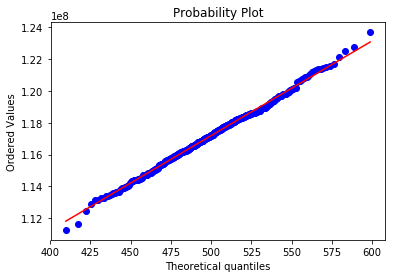

In [36]:
stats.probplot(control_boot_chi_squared, dist="chi2", sparams=499, plot=plt)[1][2] ** 2

0.99816795057865992

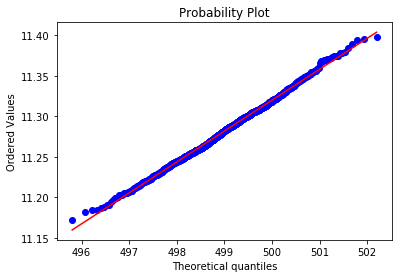

In [37]:
stats.probplot(mean_samples, sparams=499, plot=plt)[1][2] ** 2

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [43]:
data_control_grouped = data_control.groupby('userID').aggregate(sum)
data_exp_grouped = data_exp.groupby('userID').aggregate(sum)

In [44]:
stats.mannwhitneyu(data_control_grouped.n_clicks.values, data_exp_grouped.n_clicks.values)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [45]:
data_control.browser.value_counts()

Browser #4     78681
Browser #22    71825
Browser #2     55793
Browser #14    44903
Browser #20    16998
Browser #17    16354
Name: browser, dtype: int64

In [53]:
browsers = data_exp.browser.value_counts().index

In [54]:
pvals = []
for browser in browsers:
    browser_click_control = data_control[data_control.browser == browser]
    browser_click_exp = data_exp[data_exp.browser == browser]
    pvals.append(stats.mannwhitneyu(browser_click_control.n_clicks.values, browser_click_exp.n_clicks.values).pvalue)

In [56]:
import statsmodels.stats.multitest as smm

smm.multipletests(pvals, method='holm')

(array([False, False, False,  True, False, False], dtype=bool),
 array([ 0.81521235,  0.77221655,  0.1362193 ,  0.        ,  0.81521235,
         0.14960241]),
 0.008512444610847103,
 0.008333333333333333)